In [3]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import copy
import glob
import gzip
import typing
import pickle

import numpy as np
import pandas as pd
import scipy
from scipy import stats

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import patches
from matplotlib import path as mpath
import matplotlib.gridspec as gridspec
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from simple_relational_reasoning.embeddings.visualizations import *
from simple_relational_reasoning.embeddings.stimuli import UNNORMALIZE, NORM_MEAN, NORM_STD

In [4]:
PAPER_FIGURE_DIR = '/Users/guydavidson/projects/Relation-Categorization-Journal-Paper/figures'

In [5]:
def plot_triplets(triplets, plot_midlines=False, plot_diagonals=False, add_titles=True, cmap=None, save_path=None):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    if cmap is not None and isinstance (cmap, str):
        cmap = plt.get_cmap(cmap)

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if cmap is not None:
                for side in ['top', 'bottom', 'left', 'right']:
                    ax.spines[side].set_color(cmap(1 - row / n))
                    ax.spines[side].set_linewidth(3)

            if plot_midlines:
                ax.axhline(y=triplets.shape[-2] // 2, color='black', linestyle='--', alpha=0.5)
                ax.axvline(x=triplets.shape[-1] // 2, color='black', linestyle='--', alpha=0.5)
            
            if plot_diagonals:
                ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=0.5)
                ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=0.5)

            if add_titles:
                if row == 0:
                    if col == k - 1:
                        ax.set_title('Different Relation')
                    elif col == k - 2:
                        ax.set_title('Same Relation')
                    else:
                        ax.set_title(f'Habituation #{col + 1}')

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path)

    plt.show()


In [6]:
def load_tsne_outputs(file_name: str, folder: str = '../tsne_outputs/', extension: str = '.pkl.gz'):
    if not file_name.endswith(extension):
        file_name += extension

    with gzip.open(os.path.join(folder, file_name), 'rb') as f:
        return pickle.load(f)

In [7]:
baseline_tsne_outputs = load_tsne_outputs('baseline')

In [8]:
baseline_tsne_outputs[0].keys()

dict_keys(['relation', 'rotate_angle', 'seed', 'n_examples', 'transpose', 'results'])

In [9]:
[len(baseline_tsne_outputs[i]['results']) for i in range(len(baseline_tsne_outputs))]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [10]:
for i in range(len(baseline_tsne_outputs[0]['results'])):
    print(baseline_tsne_outputs[0]['results'][i].keys())

dict_keys(['mobilenet-saycam(S)', 'mobilenet-imagenet', 'mobilenet-random', 'resnext-saycam(S)', 'resnext-imagenet', 'resnext-random'])


In [11]:
baseline_tsne_outputs[0]['results'][0]['mobilenet-imagenet'].keys()


dict_keys(['different_shapes', 'split_text', 'random_color'])

In [12]:
baseline_tsne_outputs[0]['results'][0]['mobilenet-imagenet']['different_shapes'].keys()

dict_keys(['data', 'results'])

In [13]:
print(baseline_tsne_outputs[0]['results'][0]['mobilenet-imagenet']['different_shapes']['data'].shape)
print(baseline_tsne_outputs[0]['results'][0]['mobilenet-imagenet']['different_shapes']['results'].shape)

(80, 3, 224, 224)
(80, 1280)


In [14]:
VALID_FILTER_DICT_KEYS = ['relation', 'rotate_angle', 'seed', 'n_examples', 'transpose']

unique_value_sets = {key: set() for key in VALID_FILTER_DICT_KEYS}

for d in baseline_tsne_outputs:
    for key in VALID_FILTER_DICT_KEYS:
        unique_value_sets[key].add(d[key])

print(unique_value_sets)

{'relation': {'above_below', 'between'}, 'rotate_angle': {0, 135, 45, 150, 120, 90, 60, 30}, 'seed': {34}, 'n_examples': {1}, 'transpose': {False}}


In [15]:
def get_specific_results(loaded_tsne_outputs: typing.List[dict], filter_dict: typing.Dict[str, typing.Any],
    model_name: str, generator_name: str = 'split_text', print_found_results: bool = False
):

    if not all([key in VALID_FILTER_DICT_KEYS for key in filter_dict.keys()]):
        raise ValueError(f'Invalid filter_dict keys: {filter_dict.keys()}')

    valid_dicts = list(filter(lambda x: all([key in x and (x[key] == filter_dict[key]) for key in filter_dict.keys()]), loaded_tsne_outputs))

    if len(valid_dicts) == 0:
        raise ValueError(f'No valid dicts found for filter_dict: {filter_dict}')

    if print_found_results: print(f'Found {len(valid_dicts)} valid dicts for filter_dict: {filter_dict}')

    results = [d['results'][0][model_name][generator_name] for d in valid_dicts]
    if len(results) == 1:
        return results[0]

    return results

    

In [16]:
test_results = get_specific_results(baseline_tsne_outputs, dict(relation='above_below', rotate_angle=0),
    # 'resnext-saycam(S)'
    'resnext-imagenet'
    )

test_between_results = get_specific_results(baseline_tsne_outputs, dict(relation='between', rotate_angle=0),
    # 'resnext-saycam(S)'
    'resnext-imagenet'
    )

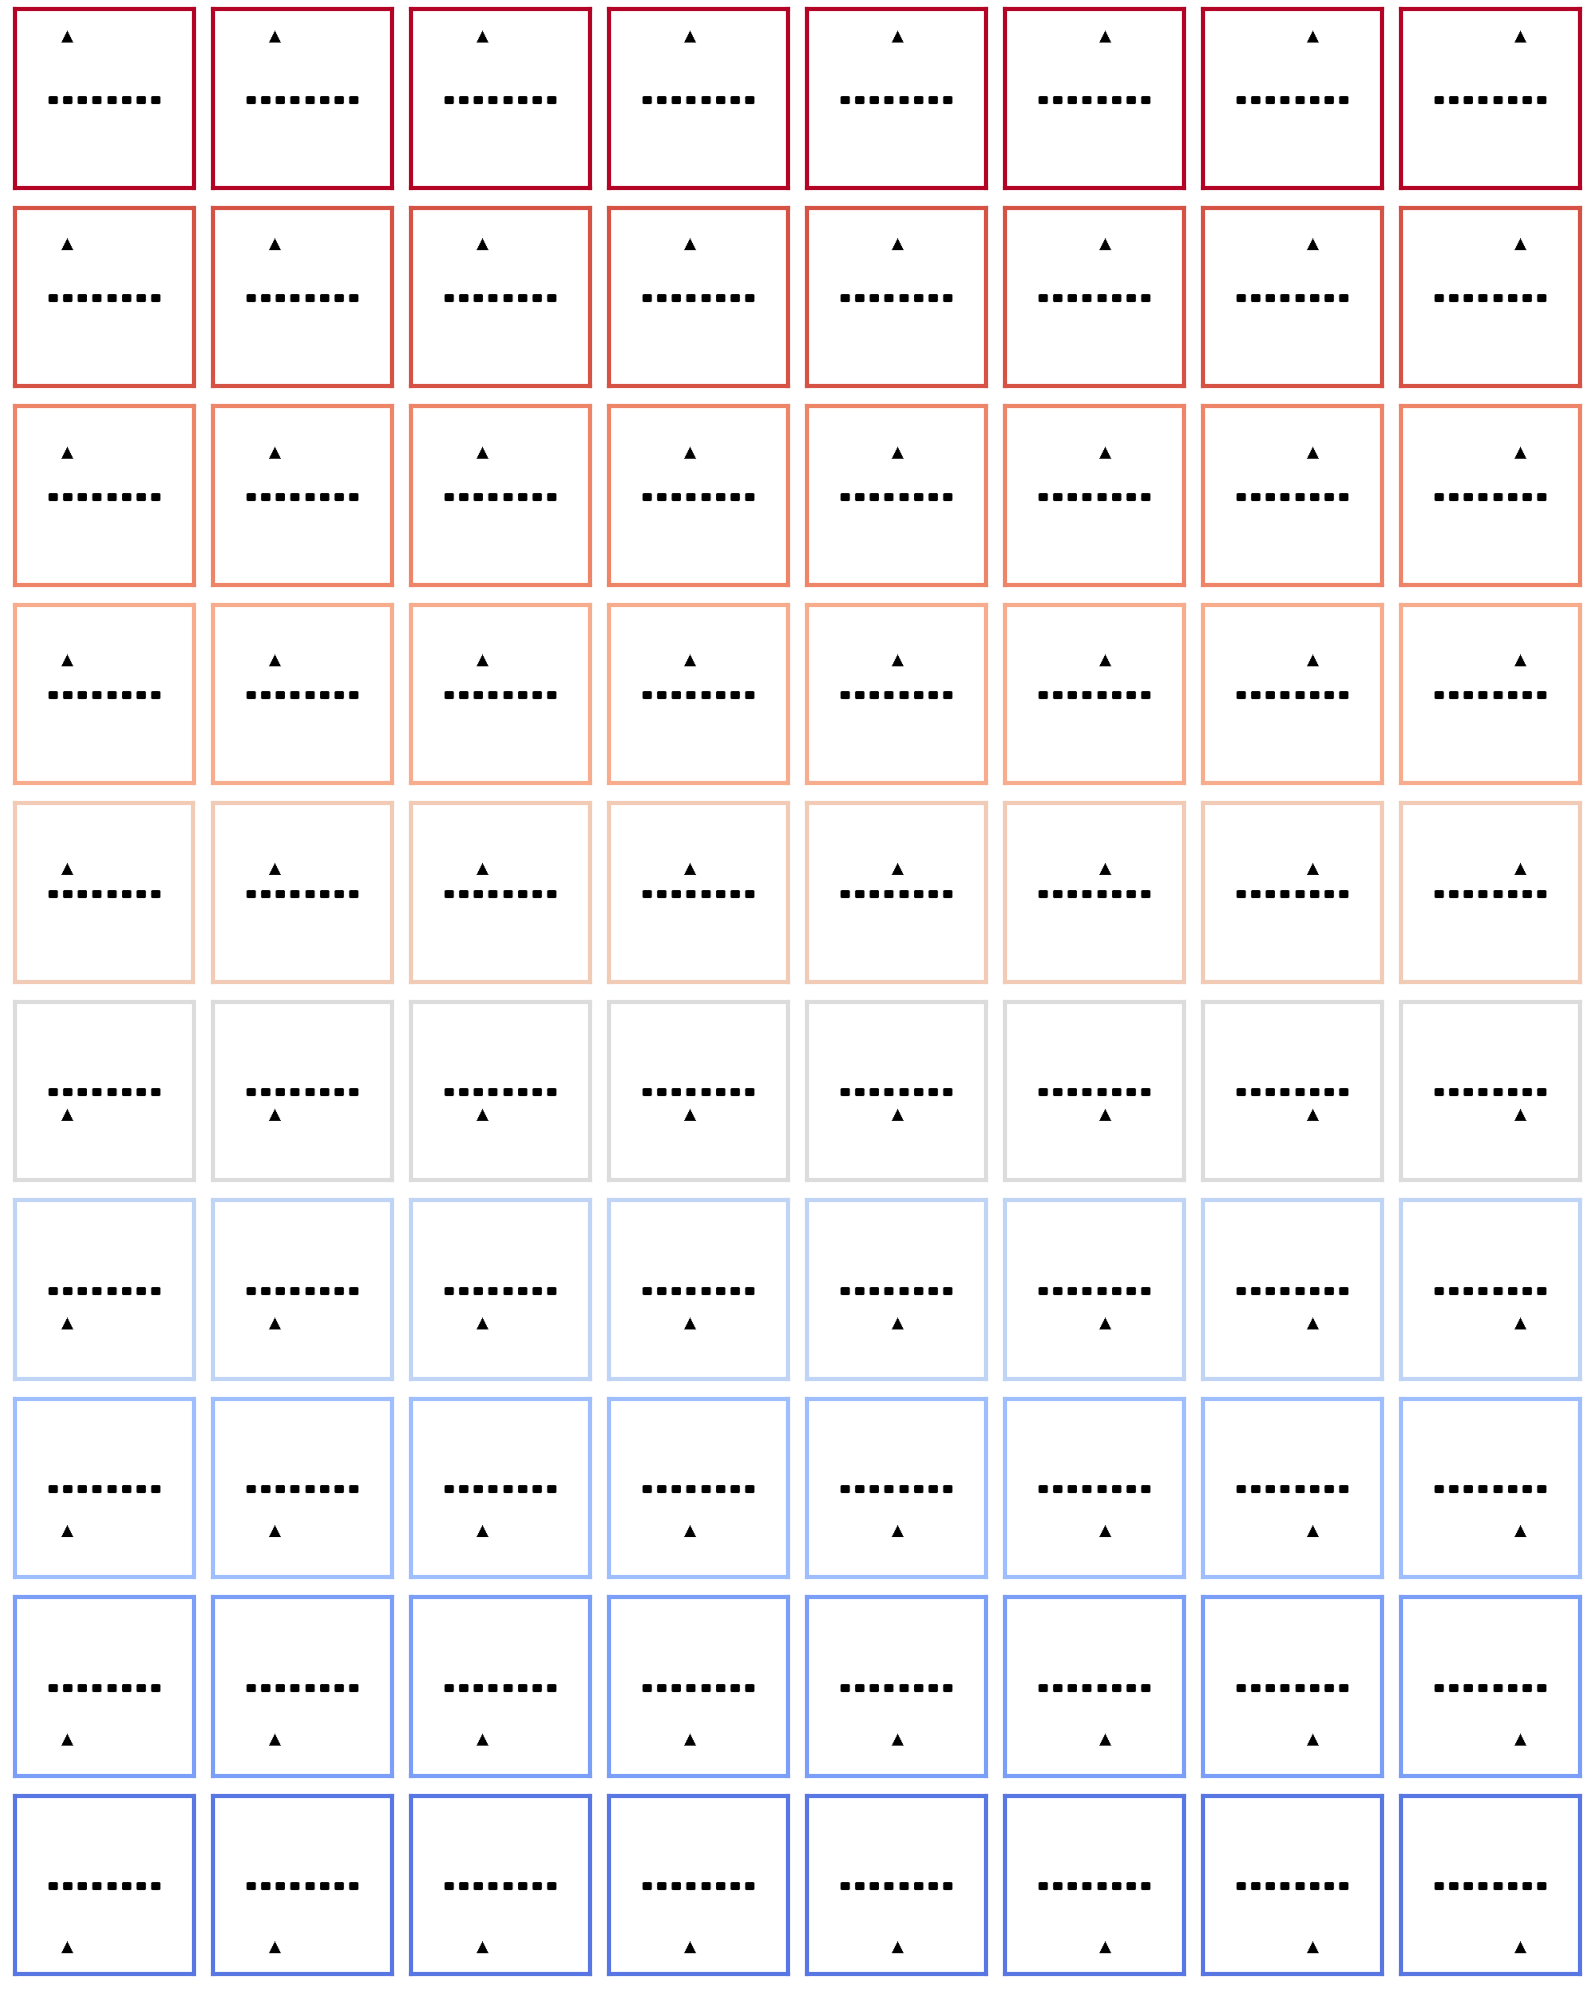

In [17]:
plot_triplets(UNNORMALIZE(torch.tensor(test_results['data']).reshape(10, 8, 3, 224, 224)), add_titles=False, cmap='coolwarm', 
              save_path=f'{PAPER_FIGURE_DIR}/exp1/tsne/above_below_tsne_stimuli.pdf')

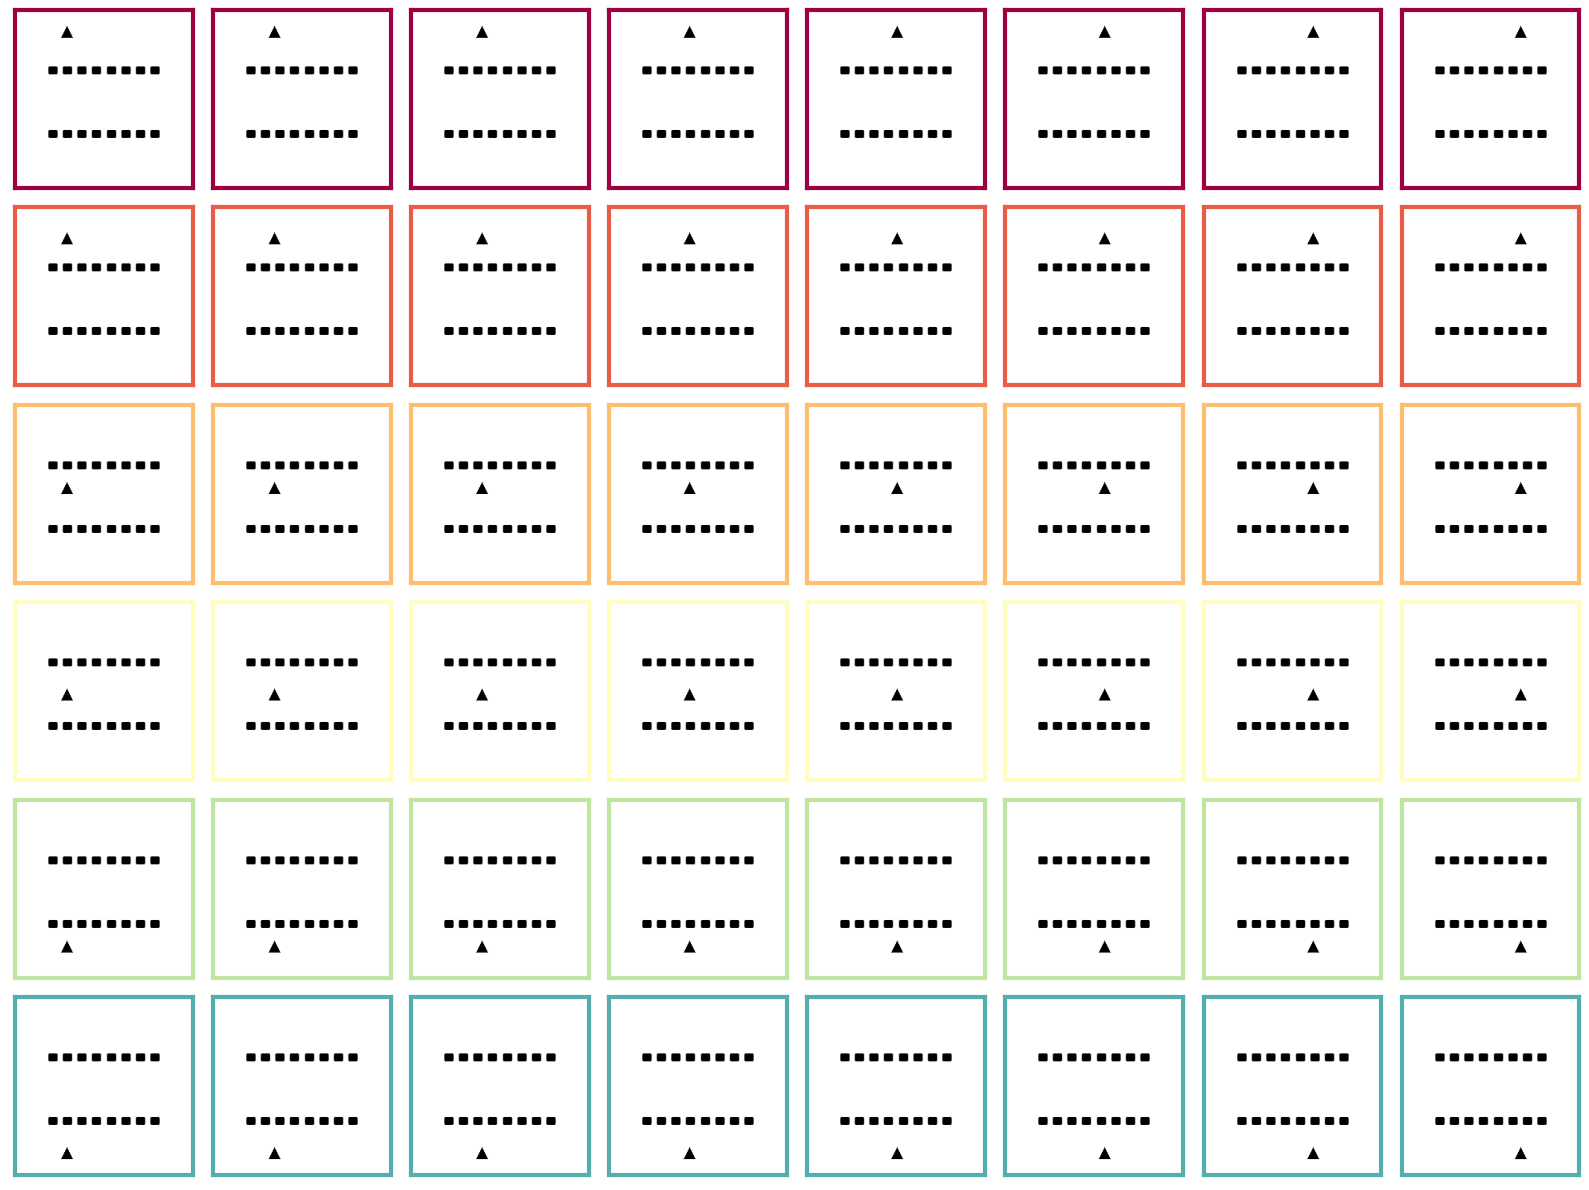

In [18]:
plot_triplets(UNNORMALIZE(torch.tensor(test_between_results['data']).reshape(6, 8, 3, 224, 224)), add_titles=False, cmap='Spectral_r',
              save_path=f'{PAPER_FIGURE_DIR}/exp1/tsne/between_tsne_stimuli.pdf')

In [31]:
PCA_N_DIM = 32
SEED = 33
PCA_KWARGS = dict(random_state=SEED)
TSNE_KAWRGS = dict(init='pca', learning_rate='auto', metric='cosine', random_state=SEED)

PCA_TSNE_CACHE = {}

def pca_and_tsne(data: np.ndarray, pca_n_dim: int = PCA_N_DIM, 
    pca_kwargs: typing.Optional[typing.Dict] = None, tsne_kwargs: typing.Optional[typing.Dict] = None,
    force_recalc: bool = False):

    key = hash(data.data.tobytes()) 
    if tsne_kwargs is not None:
        key += hash(str(tsne_kwargs))
    if pca_kwargs is not None:
        key += hash(str(pca_kwargs))
        
    if key not in PCA_TSNE_CACHE or force_recalc:
        if pca_kwargs is None:
            pca_kwargs = PCA_KWARGS
        else:
            temp_kwargs = PCA_KWARGS.copy()
            temp_kwargs.update(pca_kwargs)
            pca_kwargs = temp_kwargs

        if tsne_kwargs is None:
            tsne_kwargs = TSNE_KAWRGS

        else:
            temp_kwargs = TSNE_KAWRGS.copy()
            temp_kwargs.update(tsne_kwargs)
            tsne_kwargs = temp_kwargs

        pca = PCA(n_components=pca_n_dim, **pca_kwargs)
        data_pca = pca.fit_transform(data)
        tsne = TSNE(n_components=2, **tsne_kwargs)
        data_tsne = tsne.fit_transform(data_pca)
        PCA_TSNE_CACHE[key] = data_tsne

    return PCA_TSNE_CACHE[key]


In [32]:
FIGSIZE_PER_AX = (3.5, 3.5)
DEFAULT_TICK_PARAMS = dict(axis='both', which='both', bottom=False, top=False, labelbottom=False,
    left=False, right=False, labelleft=False)
DEFAULT_COLORBAR_AX_PARAMS = [0.9, 0.1, 0.05, 0.8]


def multi_tsne_plot(loaded_tsne_outputs: typing.List[dict], shared_load_params: typing.Dict[str, typing.Any],
    row_and_column_params: typing.List[typing.List[typing.Dict[str, typing.Any]]],
    # dimensionality reduction params
    pca_n_dim: int = PCA_N_DIM, 
    pca_kwargs: typing.Optional[typing.Dict] = None, 
    tsne_kwargs: typing.Optional[typing.Dict] = None,
    force_recalc: bool = False,
    # plot params
    figsize: typing.Optional[typing.Tuple[float, float]] = None,
    figsize_per_ax: typing.Tuple[float, float] = FIGSIZE_PER_AX,
    figure_facecolor: str = 'white', 
    scatter_c: typing.Optional[typing.Sequence[float]] = None,
    scatter_cmap: str = 'coolwarm',
    sup_title: typing.Optional[str] = None,
    subplots_adjust_params: typing.Optional[typing.Dict] = None,
    col_titles: typing.Optional[typing.List[str]] = None,
    row_titles: typing.Optional[typing.List[str]] = None,
    title_fontsize: int = 16,
    tick_params: typing.Dict[str, typing.Any] = DEFAULT_TICK_PARAMS,
    add_colorbar: bool = False,
    colorbar_labels: typing.Optional[typing.List[str]] = None,
    colorbar_ticks: typing.Optional[typing.List[float]] = None,
    colorbar_title: typing.Optional[str] = None,
    colorbar_ax_params: typing.List[float] = DEFAULT_COLORBAR_AX_PARAMS,
    colorbar_aspect: float = 20,
    colorbar_shrink: float = 1.0,
    # save params
    save_path: typing.Optional[str] = None,
    ):

    n_rows = len(row_and_column_params)
    n_cols = len(row_and_column_params[0])

    if col_titles is not None and len(col_titles) != n_cols:
        raise ValueError(f'col_titles must be of length n_cols = {n_cols}')

    if row_titles is not None and len(row_titles) != n_rows:
        raise ValueError(f'row_titles must be of length n_rows = {n_rows}')
    
    if figsize is None:
        figsize = (n_cols * figsize_per_ax[0], n_rows * figsize_per_ax[1])

    fig = plt.figure(figsize=figsize, facecolor=figure_facecolor)
    plt.tick_params(**tick_params)

    for r, row_param_list in enumerate(row_and_column_params):
        for c, ax_data_params in enumerate(row_param_list):
            ax = plt.subplot(n_rows, n_cols, r * n_cols + c + 1)
            ax.tick_params(**tick_params)

            ax_data_params = ax_data_params.copy()
            ax_data_params.update(shared_load_params)

            ax_results =  get_specific_results(loaded_tsne_outputs, **ax_data_params)
            if not isinstance(ax_results, dict):
                raise ValueError('Expected results to return one value, received multiple')

            ax_results_tsne = pca_and_tsne(ax_results['results'], pca_n_dim=pca_n_dim, pca_kwargs=pca_kwargs, tsne_kwargs=tsne_kwargs, force_recalc=force_recalc)
            ax.scatter(ax_results_tsne[:, 0], ax_results_tsne[:, 1], c=scatter_c, cmap=scatter_cmap)

            if r == 0 and row_titles is not None:
                ax.set_title(col_titles[c], fontsize=title_fontsize)

            if c == 0 and col_titles is not None:
                ax.set_ylabel(row_titles[r], fontsize=title_fontsize)

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)

    if sup_title is not None:
        plt.suptitle(sup_title, fontsize=title_fontsize + 4)

    if add_colorbar:
        if colorbar_ticks is None:
            colorbar_ticks = np.arange(len(colorbar_labels))

        colorbar_mappable = plt.cm.ScalarMappable(cmap=scatter_cmap, 
            norm=matplotlib.colors.Normalize(vmin=colorbar_ticks[0], vmax=colorbar_ticks[-1]))

        colorbar_ax = fig.add_axes(colorbar_ax_params)
        colorbar = fig.colorbar(colorbar_mappable, cax=colorbar_ax, ticks=colorbar_ticks, 
            aspect=colorbar_aspect, shrink=colorbar_shrink)
        colorbar_ax.set_yticklabels(colorbar_labels, fontdict=dict(fontsize=title_fontsize))
        if colorbar_title is not None:
            colorbar.set_label(label=colorbar_title, fontsize=title_fontsize)

    if save_path is not None:
        save_plot(save_path)

    plt.show()



In [33]:
BASELINE_RESNEXT_MODELS = ('resnext-random', 'resnext-imagenet', 'resnext-saycam(S)')
BASELINE_MOBILENET_MODELS = ('mobilenet-random', 'mobilenet-imagenet', 'mobilenet-saycam(S)')
BASELINE_TRAINING_LABELS = ('Untrained', 'ImageNet', 'SAYcam')
BASELINE_MODEL_LABELS = ('MobileNet', 'ResNeXt',)

GENERATOR_NAMES = ('different_shapes', 'split_text', 'random_color')
GENERATOR_LABELS = ('Quinn-like', 'Random Shapes', 'Random Colors')

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_13596/3259874268.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(n_rows, n_cols, r * n_cols + c + 1)


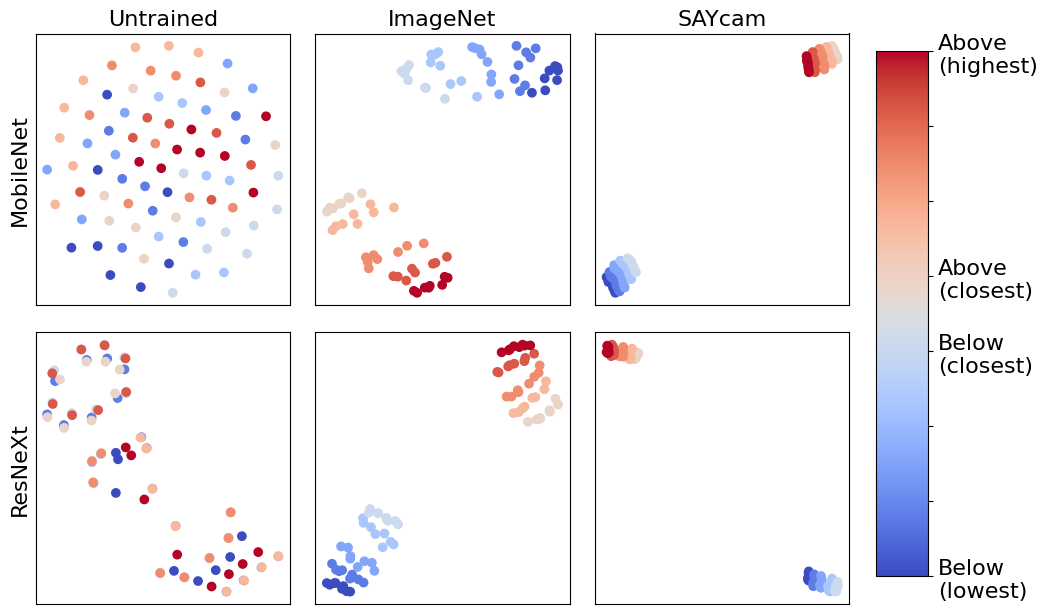

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_13596/3259874268.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(n_rows, n_cols, r * n_cols + c + 1)


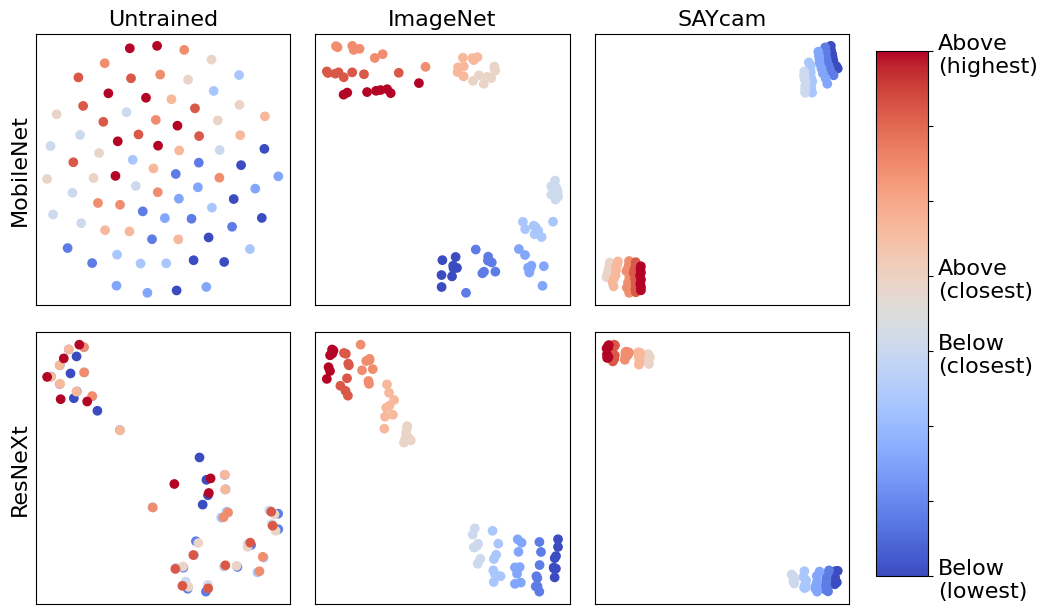

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_13596/3259874268.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(n_rows, n_cols, r * n_cols + c + 1)


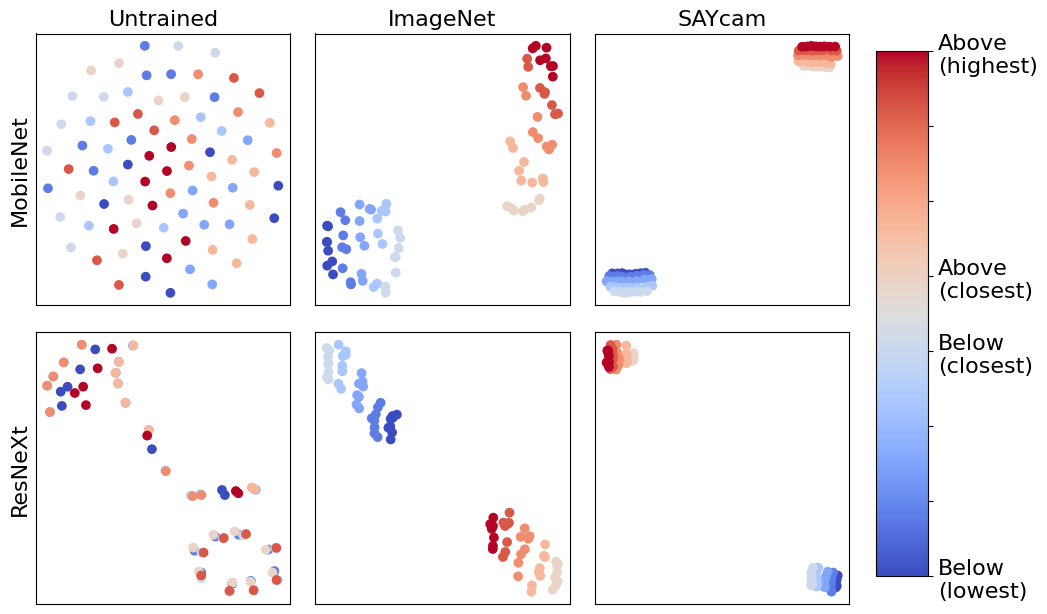

In [34]:
for generator_name in GENERATOR_NAMES:

    row_and_column_params = [
        [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_MOBILENET_MODELS],
        [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_RESNEXT_MODELS]
    ]

    multi_tsne_plot(baseline_tsne_outputs, 
        shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
        row_and_column_params=row_and_column_params,
        tsne_kwargs=dict(metric='cosine'),
        scatter_c=np.arange(80) // 8,
        col_titles=BASELINE_TRAINING_LABELS,
        row_titles=BASELINE_MODEL_LABELS,
        # sup_title='Baseline ResNeXt models by generator, above/below',
        add_colorbar=True,
        colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
        colorbar_shrink=0.8,
        colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
        # sup_title=f'Cosine distance metric with {generator_name} generator',
        # subplots_adjust_params=dict(top=0.9, wspace=0.1, hspace=0.1),
        subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
        save_path=f'{PAPER_FIGURE_DIR}/exp1/tsne/baseline_{generator_name}_above_below.pdf',
    )

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_13596/3259874268.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(n_rows, n_cols, r * n_cols + c + 1)


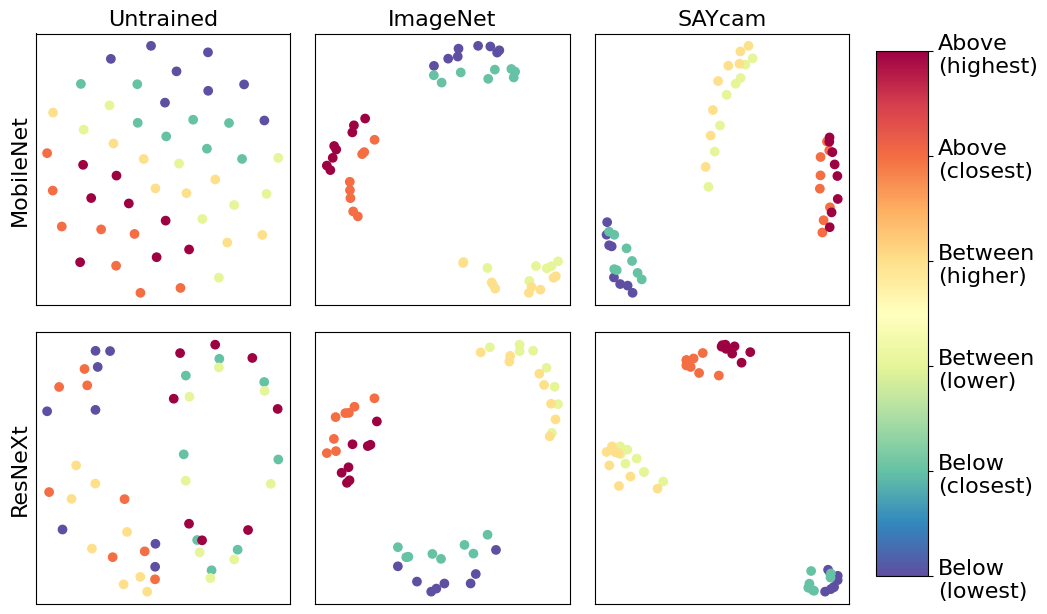

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_13596/3259874268.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(n_rows, n_cols, r * n_cols + c + 1)


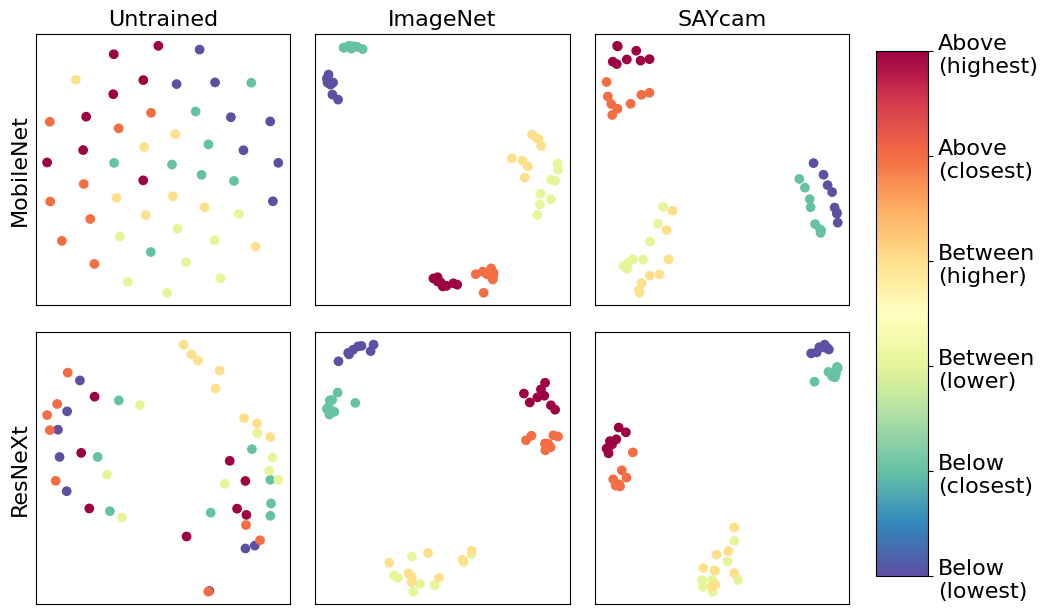

/var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/ipykernel_13596/3259874268.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(n_rows, n_cols, r * n_cols + c + 1)


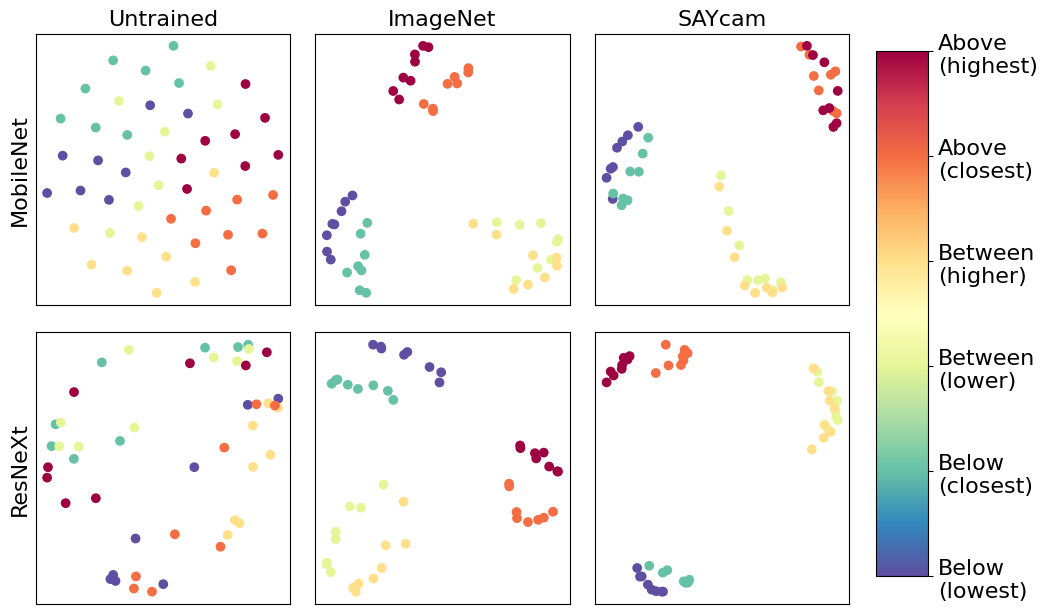

In [35]:
for generator_name in GENERATOR_NAMES:

    row_and_column_params = [
        [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_MOBILENET_MODELS],
        [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_RESNEXT_MODELS]
    ]

    multi_tsne_plot(baseline_tsne_outputs, 
        shared_load_params=dict(filter_dict=dict(relation='between', rotate_angle=0)),
        row_and_column_params=row_and_column_params,
        scatter_c=np.arange(48) // 8,
        scatter_cmap='Spectral_r',
        col_titles=BASELINE_TRAINING_LABELS,
        row_titles=BASELINE_MODEL_LABELS,
        # sup_title='Baseline ResNeXt models by generator, above/below',
        subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
        add_colorbar=True,
        colorbar_labels=['Below\n(lowest)', 'Below\n(closest)', 'Between\n(lower)', 
            'Between\n(higher)', 'Above\n(closest)', 'Above\n(highest)'],
        colorbar_shrink=0.8,
        colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
        save_path=f'{PAPER_FIGURE_DIR}/exp1/tsne/baseline_{generator_name}_between.pdf',
    )


# Previous t-SNE plots

In [ ]:
BASELINE_RESNEXT_MODELS = ('resnext-random', 'resnext-imagenet', 'resnext-saycam(S)')
BASELINE_MOBILENET_MODELS = ('mobilenet-random', 'mobilenet-imagenet', 'mobilenet-saycam(S)')
BASELINE_MODEL_LABELS = ('Untrained', 'ImageNet', 'SAYcam')

GENERATOR_NAMES = ('different_shapes', 'split_text', 'random_color')
GENERATOR_LABELS = ('Quinn-like', 'Random Shapes', 'Random Colors')

row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_RESNEXT_MODELS]
    for generator_name in GENERATOR_NAMES
]

multi_tsne_plot(baseline_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(80) // 8,
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    # sup_title='Baseline ResNeXt models by generator, above/below',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='paper/exp1/tsne/baseline_resnext_above_below.pdf',
)

In [ ]:
row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_MOBILENET_MODELS]
    for generator_name in GENERATOR_NAMES
]

multi_tsne_plot(baseline_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(80) // 8,
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    # sup_title='Baseline Mobilenet models by generator, above/below',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='paper/exp1/tsne/baseline_mobilenet_above_below.pdf',
)

In [ ]:
row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_RESNEXT_MODELS]
    for generator_name in GENERATOR_NAMES
]

multi_tsne_plot(baseline_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='between', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(48) // 8,
    scatter_cmap='Spectral',
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    # sup_title='Baseline ResNeXt models by generator, between',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', 'Below\n(closest)', 'Between\n(lower)', 
        'Between\n(higher)', 'Above\n(closest)', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='paper/exp1/tsne/baseline_resnext_between.pdf',
)

In [ ]:
row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_MOBILENET_MODELS]
    for generator_name in GENERATOR_NAMES
]

multi_tsne_plot(baseline_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='between', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(48) // 8,
    scatter_cmap='Spectral',
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    # sup_title='Baseline ResNeXt models by generator, between',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', 'Below\n(closest)', 'Between\n(lower)', 
        'Between\n(higher)', 'Above\n(closest)', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='paper/exp1/tsne/baseline_mobilenet_between.pdf',
)

In [ ]:
flipping_tsne_outputs = load_tsne_outputs('flipping')

In [ ]:
flipping_tsne_outputs[0]['results'][0].keys()

In [ ]:
FLIPPING_MODEL_NAMES = ('resnext-saycam(S)-s', 'resnext-saycam(S)-h', 'resnext-saycam(S)-v', 'resnext-saycam(S)-hv')
FLIPPING_MODEL_LABELS = ('Neither', 'Horizontal', 'Vertical', 'Both')
ROTATE_ANGLES = (0, 30, 45, 60, 90, 120, 135, 150)

GENERATOR = GENERATOR_NAMES[0]
RELATION = 'above_below'

row_and_column_params = [
    [dict(filter_dict=dict(relation=RELATION, rotate_angle=angle), 
        model_name=model_name, generator_name=GENERATOR) for angle in ROTATE_ANGLES] 
    for model_name in FLIPPING_MODEL_NAMES
]

multi_tsne_plot(flipping_tsne_outputs, 
    shared_load_params=dict(),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(80) // 8,
    col_titles=ROTATE_ANGLES,
    row_titles=FLIPPING_MODEL_LABELS,
    sup_title='Flipping models by rotate angle, above/below',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    save_path='tsne_flipping_above_below_by_angle.png',
    # add_colorbar=True,
    # colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    # colorbar_shrink=0.8,
    # colorbar_ax_params=[0.95, 0.15, 0.05, 0.75]
)

In [ ]:
GENERATOR = GENERATOR_NAMES[0]
RELATION = 'between'

row_and_column_params = [
    [dict(filter_dict=dict(relation=RELATION, rotate_angle=angle), 
        model_name=model_name, generator_name=GENERATOR) for angle in ROTATE_ANGLES] 
    for model_name in FLIPPING_MODEL_NAMES
]

multi_tsne_plot(flipping_tsne_outputs, 
    shared_load_params=dict(),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(48) // 8,
    scatter_cmap='Spectral',
    col_titles=ROTATE_ANGLES,
    row_titles=FLIPPING_MODEL_LABELS,
    sup_title='Flipping models by rotate angle, between',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    save_path='tsne_flipping_between_by_angle.png',
    # add_colorbar=True,
    # colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    # colorbar_shrink=0.8,
    # colorbar_ax_params=[0.95, 0.15, 0.05, 0.75]
)

In [ ]:
dino_tsne_outputs = load_tsne_outputs('dino')

In [ ]:
dino_tsne_outputs[0]['results'][0].keys()

In [ ]:
DINO_MODEL_NAMES = (['resnext-DINO-S', 'resnext-DINO-ImageNet'])
DINO_MODEL_LABELS = ('DINO (SAYCam)', 'DINO (ImageNet)')

GENERATOR = GENERATOR_NAMES[0]
RELATION = 'above_below'

row_and_column_params = [
    [dict(filter_dict=dict(relation=RELATION, rotate_angle=angle), 
        model_name=model_name, generator_name=GENERATOR) for angle in ROTATE_ANGLES] 
    for model_name in DINO_MODEL_NAMES
]

multi_tsne_plot(dino_tsne_outputs, 
    shared_load_params=dict(),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(80) // 8,
    col_titles=ROTATE_ANGLES,
    row_titles=DINO_MODEL_LABELS,
    sup_title='DINO models by rotate angle, above/below',
    subplots_adjust_params=dict(top=0.875, wspace=0.1, hspace=0.1),
    save_path='tsne_dino_above_below_by_angle.png',
    # add_colorbar=True,
    # colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    # colorbar_shrink=0.8,
    # colorbar_ax_params=[0.95, 0.15, 0.05, 0.75]
)

In [ ]:
GENERATOR = GENERATOR_NAMES[0]
RELATION = 'between'

row_and_column_params = [
    [dict(filter_dict=dict(relation=RELATION, rotate_angle=angle), 
        model_name=model_name, generator_name=GENERATOR) for angle in ROTATE_ANGLES] 
    for model_name in DINO_MODEL_NAMES
]

multi_tsne_plot(dino_tsne_outputs, 
    shared_load_params=dict(),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(48) // 8,
    scatter_cmap='Spectral',
    col_titles=ROTATE_ANGLES,
    row_titles=DINO_MODEL_LABELS,
    sup_title='DINO models by rotate angle, between',
    subplots_adjust_params=dict(top=0.875, wspace=0.1, hspace=0.1),
    save_path='tsne_dino_between_by_angle.png',
    # add_colorbar=True,
    # colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    # colorbar_shrink=0.8,
    # colorbar_ax_params=[0.95, 0.15, 0.05, 0.75]
)

In [ ]:
baseline_offset_tsne_outputs = load_tsne_outputs('baseline_offset_stimuli')

In [ ]:
row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_RESNEXT_MODELS]
    for generator_name in GENERATOR_NAMES
]


multi_tsne_plot(baseline_offset_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(80) // 8,
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    sup_title='Baseline ResNeXt models, offset stimuli, above/below',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='tsne_baseline_offset_stimuli_resnext_above_below_by_generator.png',
)

In [ ]:
row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_MOBILENET_MODELS]
    for generator_name in GENERATOR_NAMES
]

multi_tsne_plot(baseline_offset_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(80) // 8,
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    sup_title='Baseline Mobilenet models, offset stimuli, above/below',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='tsne_baseline_offset_stimuli_mobilenet_above_below_by_generator.png',
)

In [ ]:
offset_test_results = get_specific_results(baseline_offset_tsne_outputs, dict(relation='above_below', rotate_angle=0),
    # 'resnext-saycam(S)'
    'resnext-imagenet'
    )

In [ ]:
plot_triplets(UNNORMALIZE(torch.tensor(offset_test_results['data']).reshape(10, 8, 3, 224, 224)), add_titles=False)

In [ ]:
no_reference_same_positions_tsne_outputs = load_tsne_outputs('baseline_no_reference_same_positions')

In [ ]:
row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_MOBILENET_MODELS]
    for generator_name in GENERATOR_NAMES
]

multi_tsne_plot(no_reference_same_positions_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(80) // 8,
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    sup_title='Baseline Mobilenet models, no reference objects, above/below',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='tsne_baseline_no_reference_same_positions_mobilenet_above_below_by_generator.png',
)

In [ ]:
row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_RESNEXT_MODELS]
    for generator_name in GENERATOR_NAMES
]


multi_tsne_plot(no_reference_same_positions_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(80) // 8,
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    sup_title='Baseline ResNeXt models, no reference objects, above/below',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='tsne_baseline_no_reference_same_positions_resnext_above_below_by_generator.png',
)

In [ ]:
no_reference_full_width_tsne_outputs = load_tsne_outputs('baseline_no_reference_full_width')

In [ ]:
row_and_column_params = [
    [dict(model_name=model_name, generator_name=generator_name) for model_name in BASELINE_RESNEXT_MODELS]
    for generator_name in GENERATOR_NAMES
]


multi_tsne_plot(no_reference_full_width_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(130) // 13,
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    sup_title='Baseline ResNeXt models, full width no reference, vertical colors',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', '', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', '', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='tsne_baseline_no_reference_full_width_resnext_vertical_colors.png',
)

In [ ]:
multi_tsne_plot(no_reference_full_width_tsne_outputs, 
    shared_load_params=dict(filter_dict=dict(relation='above_below', rotate_angle=0)),
    row_and_column_params=row_and_column_params,
    scatter_c=np.arange(130) // 13,
    col_titles=BASELINE_MODEL_LABELS,
    row_titles=GENERATOR_LABELS,
    sup_title='Baseline ResNeXt models, full width no reference, vertical colors',
    subplots_adjust_params=dict(top=0.925, wspace=0.1, hspace=0.1),
    add_colorbar=True,
    colorbar_labels=['Below\n(lowest)', '', '', '', 'Below\n(closest)', 'Above\n(closest)', '', '', '', 'Above\n(highest)'],
    colorbar_shrink=0.8,
    colorbar_ax_params=[0.925, 0.15, 0.05, 0.75],
    save_path='tsne_baseline_no_reference_full_width_resnext_vertical_colors.png',
)